/Users/lucruz/Documents/GitHub/gym_gridworlds/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

/var/folders/sd/s3_0xg3x0tlfrc5189jz9r100000gp/T/ipykernel_50035/1369200013.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dlog_pi = dlog_softmax_probs(phi[t:t+1], weights, eps, int(actions[t]))



Baseline: none, Seed: 0


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 1


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 2


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 3


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 4


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 5


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 6


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 7


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 8


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: none, Seed: 9


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 0


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 1


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 2


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 3


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 4


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 5


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 6


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 7


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 8


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 9


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 0


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 1


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 2


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 3


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 4


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 5


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 6


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 7


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 8


  0%|          | 0/100000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 9


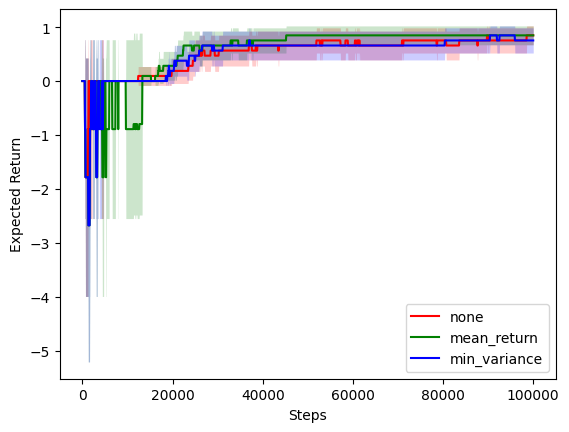

In [8]:
import gymnasium
import gym_gridworlds
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

np.set_printoptions(precision=3, suppress=True)

# https://en.wikipedia.org/wiki/Pairing_function
def cantor_pairing(x, y):
    return int(0.5 * (x + y) * (x + y + 1) + y)

def rbf_features(x: np.array, c: np.array, s: np.array) -> np.array:
    return np.exp(-(((x[:, None] - c[None]) / s[None])**2).sum(-1) / 2.0)

def expected_return(env, weights, gamma, episodes=100):
    G = np.zeros(episodes)
    for e in range(episodes):
        s, _ = env.reset(seed=e)
        done = False
        t = 0
        while not done:
            phi = get_phi(s)
            if env_id == "Pendulum-v1":
                a = np.dot(phi, weights)
                a_clip = np.clip(a, env.action_space.low, env.action_space.high)
                s_next, r, terminated, truncated, _ = env.step(a_clip)
            else:
                q = np.dot(phi, weights).ravel() # no need for the eps_greedy_action func since eps=0
                ties = np.argwhere(q == q.max())
                i = np.random.choice(range(ties.shape[0]))
                a = ties[i][0]
                s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G[e] += gamma**t * r
            s = s_next
            t += 1
    return G.mean()

def collect_data(env, weights, sigma, n_episodes):
    data = dict()
    data["phi"] = []
    data["a"] = []
    data["r"] = []
    data["done"] = []
    for ep in range(n_episodes):
        episode_seed = cantor_pairing(ep, seed)
        s, _ = env.reset(seed=episode_seed)
        done = False
        while not done:
            phi = get_phi(s)
            if env_id == "Pendulum-v1":
                a = gaussian_action(phi, weights, sigma)
                a_clip = np.clip(a, env.action_space.low, env.action_space.high)
                s_next, r, terminated, truncated, _ = env.step(a_clip)
            else:
                a = softmax_action(phi, weights, eps=1)
                s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            data["phi"].append(phi)
            data["a"].append(a)
            data["r"].append(r)
            data["done"].append(done)
            s = s_next
    return data

def softmax_probs(phi, weights, eps):
    q = np.dot(phi, weights)
    # this is a trick to make it more stable
    # see https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    q_exp = np.exp((q - np.max(q, -1, keepdims=True)) / max(eps, 1e-12))
    probs = q_exp / q_exp.sum(-1, keepdims=True)
    return probs

def softmax_action(phi, weights, eps):
    probs = softmax_probs(phi, weights, eps)
    return np.random.choice(probs.shape[1], p=probs.ravel())

def dlog_softmax_probs(phi, weights, eps, act):
    q = np.dot(phi, weights)
    q_exp = np.exp((q - np.max(q, -1, keepdims=True)) / max(eps, 1e-12))
    probs = q_exp / q_exp.sum(-1, keepdims=True)
    one_hot = np.zeros_like(probs)
    one_hot[0, act] = 1
    grad = (1 / eps) * phi.T @ (one_hot - probs)
    return grad.flatten()

def gaussian_action(phi, weights, sigma):
    mu = np.dot(phi, weights)
    a = np.random.normal(mu, sigma**2)
    return a

def dlog_gaussian_probs(phi, weights, sigma, action):
    mu = np.dot(phi, weights)
    diff = action - mu
    grad = (diff / sigma**2) * phi.T
    return grad.flatten()

def reinforce(baseline="none"):
    weights = np.zeros((phi_dummy.shape[1], action_dim))
    sigma = 2.0  # for Gaussian
    eps = 1.0  # softmax temperature, DO NOT DECAY
    tot_steps = 0
    exp_return_history = np.zeros(max_steps)
    exp_return = expected_return(env_eval, weights, gamma, episodes_eval)
    pbar = tqdm(total=max_steps)

    while tot_steps < max_steps:
        # Collect data
        data = collect_data(env, weights, sigma, episodes_per_update)
        phi = np.vstack(data["phi"])
        actions = np.vstack(data["a"])
        rewards = np.vstack(data["r"]).ravel()
        dones = np.vstack(data["done"]).ravel()
        T = len(rewards)

        # Compute MC returns
        G = np.zeros_like(rewards)
        G_t = 0
        for t in reversed(range(T)):
            if dones[t]:
                G_t = 0
            G_t = rewards[t] + gamma * G_t
            G[t] = G_t

        # compute gradients
        grads = []
        dlog_pi_norms_sq = []
        for t in range(T):
            if env_id == "Pendulum-v1":
                dlog_pi = dlog_gaussian_probs(phi[t:t+1], weights, sigma, actions[t])
            else:
                dlog_pi = dlog_softmax_probs(phi[t:t+1], weights, eps, int(actions[t]))
            grads.append(dlog_pi)
            dlog_pi_norms_sq.append(np.sum(dlog_pi ** 2))
        grads = np.array(grads)
        dlog_pi_norms_sq = np.array(dlog_pi_norms_sq)

        if baseline == "none":
            b = 0
        elif baseline == "mean_return":
            b = np.mean(G)
        elif baseline == "min_variance":
            numerator = np.sum(dlog_pi_norms_sq * G)
            denominator = np.sum(dlog_pi_norms_sq)
            b = numerator / (denominator + 1e-8)
        else:
            raise ValueError("Unknown baseline type")

        A = G - b

        gradient = grads * A[:, None]

        # average gradient over all samples
        grad_mean = gradient.mean(axis=0)

        # Update weights
        weights += alpha * grad_mean.reshape(weights.shape)

        exp_return_history[tot_steps : tot_steps + T] = exp_return

        tot_steps += T
        exp_return = expected_return(env_eval, weights, gamma, episodes_eval)
        sigma = max(sigma - T / max_steps, 0.1)

        pbar.set_description(f"G: {exp_return:.3f}")
        pbar.update(T)

    pbar.close()
    return exp_return_history

# https://stackoverflow.com/a/63458548/754136
def smooth(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
    re[0] = arr[0]
    for i in range(1, span + 1):
        re[i] = np.average(arr[: i + span])
        re[-i] = np.average(arr[-i - span :])
    return re

def error_shade_plot(ax, data, stepsize, smoothing_window=1, **kwargs):
    y = np.nanmean(data, 0)
    x = np.arange(len(y))
    x = [stepsize * step for step in range(len(y))]
    if smoothing_window > 1:
        y = smooth(y, smoothing_window)
    (line,) = ax.plot(x, y, **kwargs)
    error = np.nanstd(data, axis=0)
    if smoothing_window > 1:
        error = smooth(error, smoothing_window)
    error = 1.96 * error / np.sqrt(data.shape[0])
    ax.fill_between(x, y - error, y + error, alpha=0.2, linewidth=0.0, color=line.get_color())

# Select the environment
env_id = "Pendulum-v1"
env = gymnasium.make(env_id)
env_eval = gymnasium.make(env_id)
episodes_eval = 100
# You'll solve the Pendulum when the empirical expected return is higher than -150
# But it can get even higher, e.g., -120
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# UNCOMMENT TO SOLVE THE GRIDWORLD
env_id = "Gym-Gridworlds/Penalty-3x3-v0"
env = gymnasium.make(env_id, coordinate_observation=True, max_episode_steps=10000)
env_eval = gymnasium.make(env_id, coordinate_observation=True, max_episode_steps=10)  # 10 steps only for faster eval
episodes_eval = 1  # Max expected return will be 0.941
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Automatically set centers and sigmas
n_centers = [7] * state_dim
state_low = env.observation_space.low
state_high = env.observation_space.high
centers = np.array(
    np.meshgrid(*[
        np.linspace(
            state_low[i] - (state_high[i] - state_low[i]) / n_centers[i] * 0.1,
            state_high[i] + (state_high[i] - state_low[i]) / n_centers[i] * 0.1,
            n_centers[i],
        )
        for i in range(state_dim)
    ])
).reshape(state_dim, -1).T
sigmas = (state_high - state_low) / np.asarray(n_centers) * 0.75 + 1e-8  # Change sigmas for more/less generalization
get_phi = lambda state : rbf_features(state.reshape(-1, state_dim), centers, sigmas)  # Reshape because feature functions expect shape (N, S)
phi_dummy = get_phi(env.reset()[0])  # To get the number of features

# Hyperparameters
gamma = 0.99
alpha = 0.1
episodes_per_update = 10
# max_steps = 1_000_000  # 100_000 for the Gridworld
max_steps = 100_000  # 1_000_000 for the Pendulum
baselines = ["none", "mean_return", "min_variance"]
n_seeds = 10
results_exp_ret = np.zeros((
    len(baselines),
    n_seeds,
    max_steps,
))

fig, axs = plt.subplots(1, 1)
axs.set_prop_cycle(color=["red", "green", "blue"])
axs.set_xlabel("Steps")
axs.set_ylabel("Expected Return")

for i, baseline in enumerate(baselines):
    for seed in range(n_seeds):
        np.random.seed(seed)
        exp_return_history = reinforce(baseline)
        results_exp_ret[i, seed] = exp_return_history
        print(f"Baseline: {baseline}, Seed: {seed}")

    plot_args = dict(
        stepsize=1,
        smoothing_window=20,
        label=baseline,
    )
    error_shade_plot(
        axs,
        results_exp_ret[i],
        **plot_args,
    )
    axs.legend()

plt.show()


/Users/lucruz/Documents/GitHub/gym_gridworlds/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/lucruz/Documents/GitHub/gym_gridworlds/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
/var/folders/sd/s3_0xg3x0tlfrc5189jz9r100000gp/T/ipykernel_50035/2748346320.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G[e] += gamma**t * r


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 0


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 2


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 3


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: none, Seed: 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 0


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 2


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 3


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: mean_return, Seed: 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 0


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 2


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 3


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

Baseline: min_variance, Seed: 9


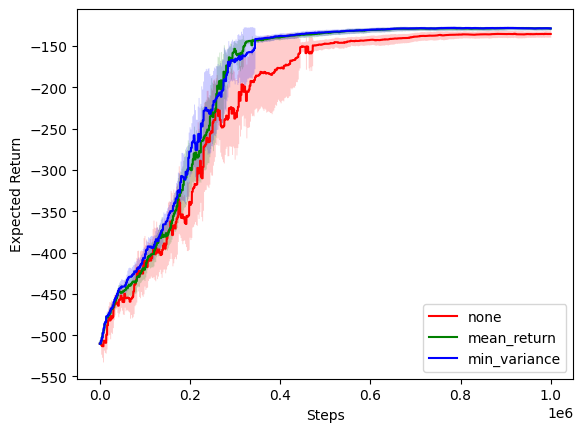

In [9]:
import gymnasium
import gym_gridworlds
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

np.set_printoptions(precision=3, suppress=True)

# https://en.wikipedia.org/wiki/Pairing_function
def cantor_pairing(x, y):
    return int(0.5 * (x + y) * (x + y + 1) + y)

def rbf_features(x: np.array, c: np.array, s: np.array) -> np.array:
    return np.exp(-(((x[:, None] - c[None]) / s[None])**2).sum(-1) / 2.0)

def expected_return(env, weights, gamma, episodes=100):
    G = np.zeros(episodes)
    for e in range(episodes):
        s, _ = env.reset(seed=e)
        done = False
        t = 0
        while not done:
            phi = get_phi(s)
            if env_id == "Pendulum-v1":
                a = np.dot(phi, weights)
                a_clip = np.clip(a, env.action_space.low, env.action_space.high)
                s_next, r, terminated, truncated, _ = env.step(a_clip)
            else:
                q = np.dot(phi, weights).ravel() # no need for the eps_greedy_action func since eps=0
                ties = np.argwhere(q == q.max())
                i = np.random.choice(range(ties.shape[0]))
                a = ties[i][0]
                s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G[e] += gamma**t * r
            s = s_next
            t += 1
    return G.mean()

def collect_data(env, weights, sigma, n_episodes):
    data = dict()
    data["phi"] = []
    data["a"] = []
    data["r"] = []
    data["done"] = []
    for ep in range(n_episodes):
        episode_seed = cantor_pairing(ep, seed)
        s, _ = env.reset(seed=episode_seed)
        done = False
        while not done:
            phi = get_phi(s)
            if env_id == "Pendulum-v1":
                a = gaussian_action(phi, weights, sigma)
                a_clip = np.clip(a, env.action_space.low, env.action_space.high)
                s_next, r, terminated, truncated, _ = env.step(a_clip)
            else:
                a = softmax_action(phi, weights, eps=1)
                s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            data["phi"].append(phi)
            data["a"].append(a)
            data["r"].append(r)
            data["done"].append(done)
            s = s_next
    return data

def softmax_probs(phi, weights, eps):
    q = np.dot(phi, weights)
    # this is a trick to make it more stable
    # see https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    q_exp = np.exp((q - np.max(q, -1, keepdims=True)) / max(eps, 1e-12))
    probs = q_exp / q_exp.sum(-1, keepdims=True)
    return probs

def softmax_action(phi, weights, eps):
    probs = softmax_probs(phi, weights, eps)
    return np.random.choice(probs.shape[1], p=probs.ravel())

def dlog_softmax_probs(phi, weights, eps, act):
    q = np.dot(phi, weights)
    q_exp = np.exp((q - np.max(q, -1, keepdims=True)) / max(eps, 1e-12))
    probs = q_exp / q_exp.sum(-1, keepdims=True)
    one_hot = np.zeros_like(probs)
    one_hot[0, act] = 1
    grad = (1 / eps) * phi.T @ (one_hot - probs)
    return grad.flatten()

def gaussian_action(phi, weights, sigma):
    mu = np.dot(phi, weights)
    a = np.random.normal(mu, sigma**2)
    return a

def dlog_gaussian_probs(phi, weights, sigma, action):
    mu = np.dot(phi, weights)
    diff = action - mu
    grad = (diff / sigma**2) * phi.T
    return grad.flatten()

def reinforce(baseline="none"):
    weights = np.zeros((phi_dummy.shape[1], action_dim))
    sigma = 2.0  # for Gaussian
    eps = 1.0  # softmax temperature, DO NOT DECAY
    tot_steps = 0
    exp_return_history = np.zeros(max_steps)
    exp_return = expected_return(env_eval, weights, gamma, episodes_eval)
    pbar = tqdm(total=max_steps)

    while tot_steps < max_steps:
        # Collect data
        data = collect_data(env, weights, sigma, episodes_per_update)
        phi = np.vstack(data["phi"])
        actions = np.vstack(data["a"])
        rewards = np.vstack(data["r"]).ravel()
        dones = np.vstack(data["done"]).ravel()
        T = len(rewards)

        # Compute MC returns
        G = np.zeros_like(rewards)
        G_t = 0
        for t in reversed(range(T)):
            if dones[t]:
                G_t = 0
            G_t = rewards[t] + gamma * G_t
            G[t] = G_t

        # compute gradients
        grads = []
        dlog_pi_norms_sq = []
        for t in range(T):
            if env_id == "Pendulum-v1":
                dlog_pi = dlog_gaussian_probs(phi[t:t+1], weights, sigma, actions[t])
            else:
                dlog_pi = dlog_softmax_probs(phi[t:t+1], weights, eps, int(actions[t]))
            grads.append(dlog_pi)
            dlog_pi_norms_sq.append(np.sum(dlog_pi ** 2))
        grads = np.array(grads)
        dlog_pi_norms_sq = np.array(dlog_pi_norms_sq)

        if baseline == "none":
            b = 0
        elif baseline == "mean_return":
            b = np.mean(G)
        elif baseline == "min_variance":
            numerator = np.sum(dlog_pi_norms_sq * G)
            denominator = np.sum(dlog_pi_norms_sq)
            b = numerator / (denominator + 1e-8)
        else:
            raise ValueError("Unknown baseline type")

        A = G - b

        gradient = grads * A[:, None]

        # average gradient over all samples
        grad_mean = gradient.mean(axis=0)

        # Update weights
        weights += alpha * grad_mean.reshape(weights.shape)

        exp_return_history[tot_steps : tot_steps + T] = exp_return

        tot_steps += T
        exp_return = expected_return(env_eval, weights, gamma, episodes_eval)
        sigma = max(sigma - T / max_steps, 0.1)

        pbar.set_description(f"G: {exp_return:.3f}")
        pbar.update(T)

    pbar.close()
    return exp_return_history

# https://stackoverflow.com/a/63458548/754136
def smooth(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
    re[0] = arr[0]
    for i in range(1, span + 1):
        re[i] = np.average(arr[: i + span])
        re[-i] = np.average(arr[-i - span :])
    return re

def error_shade_plot(ax, data, stepsize, smoothing_window=1, **kwargs):
    y = np.nanmean(data, 0)
    x = np.arange(len(y))
    x = [stepsize * step for step in range(len(y))]
    if smoothing_window > 1:
        y = smooth(y, smoothing_window)
    (line,) = ax.plot(x, y, **kwargs)
    error = np.nanstd(data, axis=0)
    if smoothing_window > 1:
        error = smooth(error, smoothing_window)
    error = 1.96 * error / np.sqrt(data.shape[0])
    ax.fill_between(x, y - error, y + error, alpha=0.2, linewidth=0.0, color=line.get_color())

# Select the environment
env_id = "Pendulum-v1"
env = gymnasium.make(env_id)
env_eval = gymnasium.make(env_id)
episodes_eval = 100
# You'll solve the Pendulum when the empirical expected return is higher than -150
# But it can get even higher, e.g., -120
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# UNCOMMENT TO SOLVE THE GRIDWORLD
# env_id = "Gym-Gridworlds/Penalty-3x3-v0"
# env = gymnasium.make(env_id, coordinate_observation=True, max_episode_steps=10000)
# env_eval = gymnasium.make(env_id, coordinate_observation=True, max_episode_steps=10)  # 10 steps only for faster eval
# episodes_eval = 1  # Max expected return will be 0.941
# state_dim = env.observation_space.shape[0]
# action_dim = env.action_space.n

# Automatically set centers and sigmas
n_centers = [7] * state_dim
state_low = env.observation_space.low
state_high = env.observation_space.high
centers = np.array(
    np.meshgrid(*[
        np.linspace(
            state_low[i] - (state_high[i] - state_low[i]) / n_centers[i] * 0.1,
            state_high[i] + (state_high[i] - state_low[i]) / n_centers[i] * 0.1,
            n_centers[i],
        )
        for i in range(state_dim)
    ])
).reshape(state_dim, -1).T
sigmas = (state_high - state_low) / np.asarray(n_centers) * 0.75 + 1e-8  # Change sigmas for more/less generalization
get_phi = lambda state : rbf_features(state.reshape(-1, state_dim), centers, sigmas)  # Reshape because feature functions expect shape (N, S)
phi_dummy = get_phi(env.reset()[0])  # To get the number of features

# Hyperparameters
gamma = 0.99
alpha = 0.1
episodes_per_update = 10
max_steps = 1_000_000  # 100_000 for the Gridworld
# max_steps = 100_000  # 1_000_000 for the Pendulum
baselines = ["none", "mean_return", "min_variance"]
n_seeds = 10
results_exp_ret = np.zeros((
    len(baselines),
    n_seeds,
    max_steps,
))

fig, axs = plt.subplots(1, 1)
axs.set_prop_cycle(color=["red", "green", "blue"])
axs.set_xlabel("Steps")
axs.set_ylabel("Expected Return")

for i, baseline in enumerate(baselines):
    for seed in range(n_seeds):
        np.random.seed(seed)
        exp_return_history = reinforce(baseline)
        results_exp_ret[i, seed] = exp_return_history
        print(f"Baseline: {baseline}, Seed: {seed}")

    plot_args = dict(
        stepsize=1,
        smoothing_window=20,
        label=baseline,
    )
    error_shade_plot(
        axs,
        results_exp_ret[i],
        **plot_args,
    )
    axs.legend()

plt.show()